<a href="https://colab.research.google.com/github/DeepankarAcharyya/Time_Series_Data/blob/master/Time_Series_Analysis_Stock_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error

In [0]:
from  scipy.optimize import minimize
import statsmodels.tsa as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

Error Metric:

In [0]:
def mean_absolute_percentage_error(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred)/ y_true))*100

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
%matplotlib inline

In [0]:
data=pd.read_csv('TATAPOWER.NS.csv', index_col=['Date'], parse_dates=['Date'])

In [10]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-06-03,69.000000,69.250000,67.750000,68.349998,65.743179,4792922.0
2019-06-04,67.500000,68.000000,66.449997,66.699997,65.400002,4864404.0
2019-06-06,66.750000,66.949997,64.650002,65.099998,65.099998,4982307.0
2019-06-07,65.000000,66.599998,64.050003,66.300003,66.300003,4984037.0
2019-06-10,66.650002,67.300003,65.949997,66.550003,66.550003,4586585.0


Cleaning the Data:

In [11]:
drop_cols=['Adj Close', 'Volume']

data.drop(drop_cols, axis=1, inplace=True)

data.head()

,Open,High,Low,Close
Date,,,,
2019-06-03,69.000000,69.250000,67.750000,68.349998
2019-06-04,67.500000,68.000000,66.449997,66.699997
2019-06-06,66.750000,66.949997,64.650002,65.099998
2019-06-07,65.000000,66.599998,64.050003,66.300003
2019-06-10,66.650002,67.300003,65.949997,66.550003


Exploratory Data Analysis (EDA) :

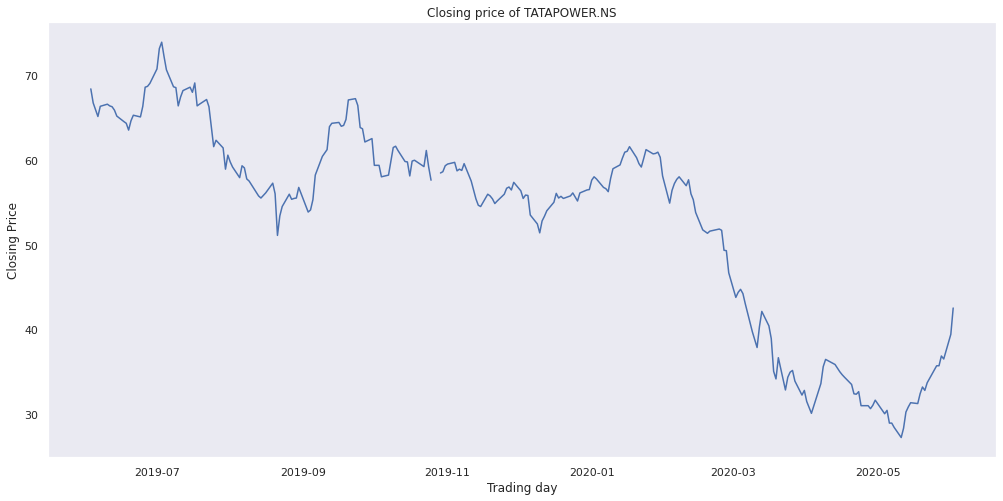

In [13]:
#plotting the closing price

plt.figure(figsize=(17,8))
plt.plot(data.Close)
plt.title('Closing price of TATAPOWER.NS')
plt.ylabel('Closing Price')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

- This is not a stationary process
- Hard to tell about the seasonality

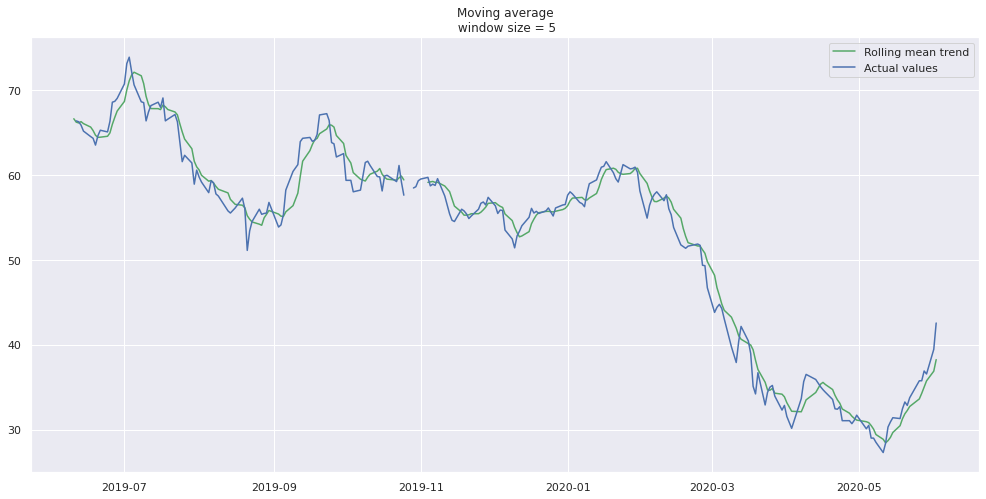

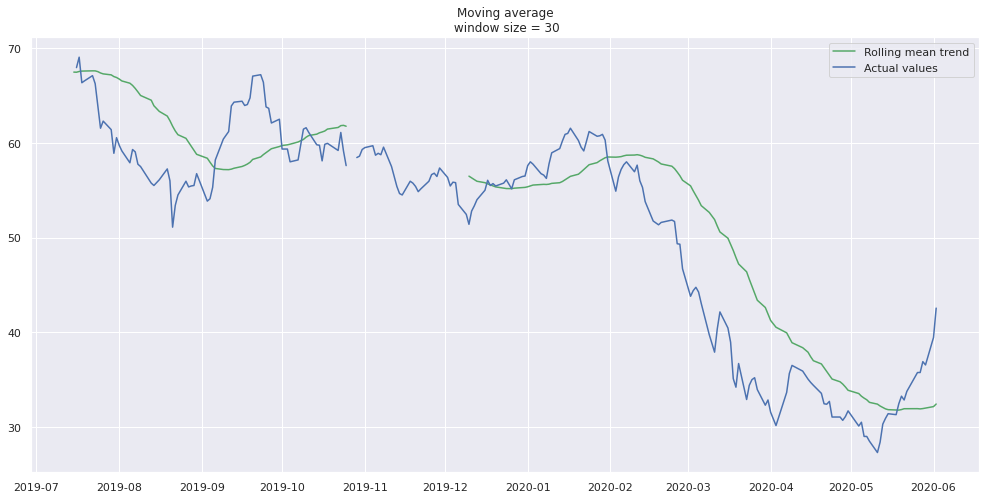

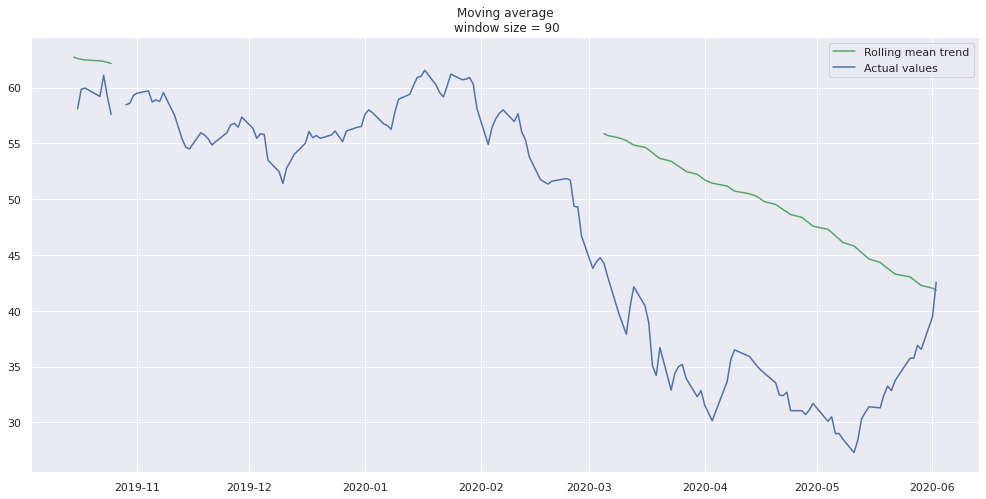

In [14]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(data.Close, 5)

#Smooth by the previous month (30 days)
plot_moving_average(data.Close, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data.Close, 90)